In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats
from scipy.stats import entropy
import warnings
import os

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

RCP_PATH = "rcp_trump_approval.csv"
JAN1_PATH = "kalshi-price-history-kxaprpotuseoy-26jan01-minute.csv"
JAN9_PATH = "kalshi-price-history-kxaprpotus-26jan09-minute.csv"
JAN30_PATH = "kalshi-price-history-kxaprpotus-26jan30-minute.csv"
OUTPUT_DIR = "plots"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [2]:
# load rcp polling
rcp = pd.read_csv(RCP_PATH)
rcp['date'] = pd.to_datetime(rcp['date'], format='mixed', dayfirst=False)
for col in ['approve', 'disapprove']:
    if rcp[col].dtype == object:
        rcp[col] = rcp[col].str.replace('%', '').astype(float)
rcp = rcp.sort_values('date').reset_index(drop=True)
rcp['net_approval'] = rcp['approve'] - rcp['disapprove']
rcp['approve_delta'] = rcp['approve'].diff()

print(f"RCP: {len(rcp)} rows, {rcp['date'].min().date()} to {rcp['date'].max().date()}")
print(f"Approval: {rcp['approve'].max():.1f}% -> {rcp['approve'].min():.1f}% ({rcp['approve'].max() - rcp['approve'].min():.1f}pp swing)")
rcp.head(15)

RCP: 376 rows, 2025-01-27 to 2026-02-06
Approval: 50.5% -> 42.2% (8.3pp swing)


,date,approve,disapprove,net_approval,approve_delta
0,2025-01-27,50.5,44.3,6.2,NaN
1,2025-01-28,50.4,44.5,5.9,-0.1
2,2025-01-29,50.3,44.8,5.5,-0.1
3,2025-01-30,50.2,44.6,5.6,-0.1
4,2025-01-31,49.9,44.7,5.2,-0.3
5,2025-02-01,49.9,44.7,5.2,0.0
6,2025-02-02,49.6,44.6,5.0,-0.3
7,2025-02-03,49.4,44.8,4.6,-0.2
8,2025-02-04,49.2,44.8,4.4,-0.2
9,2025-02-05,49.0,44.9,4.1,-0.2


In [3]:
# load kalshi markets
def load_kalshi(path):
    df = pd.read_csv(path)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.fillna(0)
    return df

jan1 = load_kalshi(JAN1_PATH)
jan9 = load_kalshi(JAN9_PATH)
jan30 = load_kalshi(JAN30_PATH)

for name, df in [("Jan1", jan1), ("Jan9", jan9), ("Jan30", jan30)]:
    bucket_cols = [c for c in df.columns if c != 'timestamp']
    print(f"{name}: {len(df)} ticks, {len(bucket_cols)} buckets, spans {df['timestamp'].max() - df['timestamp'].min()}")

Jan1: 5466 ticks, 12 buckets, spans 105 days 10:51:00
Jan9: 2524 ticks, 8 buckets, spans 6 days 20:18:00
Jan30: 726 ticks, 8 buckets, spans 6 days 10:56:00


In [4]:
# parse bucket column names into midpoints (e.g. "42.0 to 42.9" -> 42.45)
def guess_midpoint(col_name):
    col = col_name.strip()
    if 'or below' in col.lower():
        return float(col.lower().replace('or below', '').strip()) - 0.45
    elif 'or above' in col.lower():
        return float(col.lower().replace('or above', '').strip()) + 0.45
    elif ' to ' in col:
        parts = col.split(' to ')
        return (float(parts[0].strip()) + float(parts[1].strip())) / 2
    return None

def build_midpoints(df):
    midpoints = {}
    for col in [c for c in df.columns if c != 'timestamp']:
        mid = guess_midpoint(col)
        if mid is not None:
            midpoints[col] = mid
        else:
            print(f"  WARNING: couldn't parse '{col}'")
    return midpoints

jan1_midpoints = build_midpoints(jan1)
jan9_midpoints = build_midpoints(jan9)
jan30_midpoints = build_midpoints(jan30)

for name, mp in [("Jan1", jan1_midpoints), ("Jan9", jan9_midpoints), ("Jan30", jan30_midpoints)]:
    vals = list(mp.values())
    width = np.mean(np.diff(sorted(vals))) if len(vals) > 1 else 0
    print(f"{name}: {len(mp)} buckets, ~{width:.2f}pp wide, range [{min(vals):.1f}, {max(vals):.1f}]")

Jan1: 12 buckets, ~1.01pp wide, range [39.4, 50.6]
Jan9: 8 buckets, ~0.49pp wide, range [41.4, 44.9]
Jan30: 8 buckets, ~0.40pp wide, range [41.4, 44.2]


In [5]:
# treat bucket prices as unnormalized probabilities, normalize,
# then get implied mean/median/mode/std/entropy
def compute_implied_stats(df, midpoints, timestamp_col='timestamp'):
    bucket_cols = [c for c in df.columns if c != timestamp_col]
    results = []

    for _, row in df.iterrows():
        prices = {midpoints[col]: row[col] for col in bucket_cols if col in midpoints}
        total = sum(prices.values())

        if total == 0:
            results.append({'timestamp': row[timestamp_col], 'implied_mean': np.nan,
                          'implied_median': np.nan, 'implied_mode': np.nan,
                          'total_probability': 0, 'n_active_buckets': 0,
                          'shannon_entropy': np.nan, 'implied_std': np.nan})
            continue

        probs = {k: v / total for k, v in prices.items()}
        implied_mean = sum(k * v for k, v in probs.items())
        implied_var = sum(v * (k - implied_mean) ** 2 for k, v in probs.items())
        implied_mode = max(probs, key=probs.get)

        sorted_items = sorted(probs.items())
        cumulative = 0
        implied_median = sorted_items[0][0]
        for midpoint, prob in sorted_items:
            cumulative += prob
            if cumulative >= 0.5:
                implied_median = midpoint
                break

        prob_array = np.array([v for v in probs.values() if v > 0])

        results.append({
            'timestamp': row[timestamp_col], 'implied_mean': implied_mean,
            'implied_median': implied_median, 'implied_mode': implied_mode,
            'total_probability': total, 'n_active_buckets': sum(1 for v in prices.values() if v > 0),
            'shannon_entropy': entropy(prob_array), 'implied_std': np.sqrt(implied_var)
        })

    return pd.DataFrame(results)

jan1_stats = compute_implied_stats(jan1, jan1_midpoints)
jan9_stats = compute_implied_stats(jan9, jan9_midpoints)
jan30_stats = compute_implied_stats(jan30, jan30_midpoints)

for name, s in [("Jan1", jan1_stats), ("Jan9", jan9_stats), ("Jan30", jan30_stats)]:
    print(f"{name}: mean {s['implied_mean'].min():.2f}-{s['implied_mean'].max():.2f}, "
          f"std {s['implied_std'].mean():.2f}, entropy {s['shannon_entropy'].mean():.2f}")

Jan1: mean 41.78-45.20, std 2.36, entropy 1.77
Jan9: mean 42.74-44.44, std 0.82, entropy 1.58
Jan30: mean 41.45-43.20, std 0.49, entropy 1.53


In [6]:
# forward-fill to 1-min grid to see how long the market sat at each level
def resample_kalshi(df, midpoints, freq='1min'):
    df_indexed = df.set_index('timestamp')
    full_range = pd.date_range(start=df_indexed.index.min(), end=df_indexed.index.max(), freq=freq)
    resampled = df_indexed.reindex(full_range, method='ffill')
    resampled.index.name = 'timestamp'
    return compute_implied_stats(resampled.reset_index(), midpoints)

jan1_resampled = resample_kalshi(jan1, jan1_midpoints)
jan9_resampled = resample_kalshi(jan9, jan9_midpoints)
jan30_resampled = resample_kalshi(jan30, jan30_midpoints)

for name, raw, res in [("Jan1", jan1, jan1_resampled), ("Jan9", jan9, jan9_resampled), ("Jan30", jan30, jan30_resampled)]:
    print(f"{name}: {len(raw)} trades -> {len(res)} minutes")

Jan1: 5466 trades -> 151852 minutes
Jan9: 2524 trades -> 9859 minutes
Jan30: 726 trades -> 9297 minutes


In [7]:
def detect_jumps(stats_df, col='implied_mean', z_thresh=3.5, min_pp=0.15):
    """
    jump detection for Kalshi implied approval data.
    
    a tick is flagged as a jump if its rolling z-score exceeds z_thresh
    AND its absolute price change exceeds min_pp percentage points.
    """
    
    df = stats_df.dropna(subset=[col]).copy()
    if len(df) < 5:
        return pd.DataFrame(columns=['timestamp', col, 'change', 'z_score', 'direction'])

    # compute density metrics for logging
    total_ticks = len(df)
    time_span_days = (df['timestamp'].max() - df['timestamp'].min()).total_seconds() / 86400
    time_span_days = max(time_span_days, 0.01)
    ticks_per_day = total_ticks / time_span_days
    median_gap_sec = df['timestamp'].diff().dropna().median().total_seconds()

    print(f"  density: {ticks_per_day:.1f} ticks/day, "
          f"median gap: {median_gap_sec:.0f}s, "
          f"span: {time_span_days:.1f} days, "
          f"n={total_ticks}")

    # compute tick-over-tick changes and rolling z-score
    df['change'] = df[col].diff()
    window = int(np.clip(total_ticks * 0.05, 20, 100))
    min_periods = max(5, window // 5)

    roll_mean = df['change'].rolling(window, min_periods=min_periods).mean()
    roll_std = df['change'].rolling(window, min_periods=min_periods).std()
    # backfill early ticks with expanding window estimate
    roll_mean = roll_mean.fillna(df['change'].expanding(min_periods=2).mean())
    roll_std = roll_std.fillna(df['change'].expanding(min_periods=2).std())

    df['z_score'] = (df['change'] - roll_mean) / roll_std.clip(lower=1e-6)

    print(f"  params: window={window}, z_thresh={z_thresh}, min_pp={min_pp}pp")

    # flag jumps: z-score AND minimum size
    df['is_jump'] = (df['z_score'].abs() > z_thresh) & (df['change'].abs() > min_pp)

    jumps = df[df['is_jump']].copy()
    if len(jumps) == 0:
        print(f"  → 0 jumps detected")
        return pd.DataFrame(columns=['timestamp', col, 'change', 'z_score', 'direction'])

    # group nearby jumps so one move isn't split into multiple flags
    min_gap_sec = 3600 if time_span_days < 10 else 1800
    group_gap_sec = np.clip(median_gap_sec * 15, min_gap_sec, 7200)
    group_gap = pd.Timedelta(seconds=group_gap_sec)

    jumps['group'] = (jumps['timestamp'].diff() > group_gap).cumsum()
    jumps = jumps.loc[jumps.groupby('group')['change'].apply(lambda x: x.abs().idxmax())]
    jumps['direction'] = jumps['change'].apply(lambda x: 'up' if x > 0 else 'down')

    print(f"  → {len(jumps)} jumps detected (group gap: {group_gap_sec/60:.0f}min)")
    return jumps[['timestamp', col, 'change', 'z_score', 'direction']].copy()


def plot_jumps(datasets, z_thresh=3.5, min_pp=0.15, save_path=None):
    """
    run detection and plot for multiple datasets.
    """
    n = len(datasets)
    fig, axes = plt.subplots(n, 1, figsize=(18, 4.5 * n))
    if n == 1:
        axes = [axes]

    for ax, (name, stats_df) in zip(axes, datasets):
        print(f"\n{name}:")
        ax.plot(stats_df['timestamp'], stats_df['implied_mean'],
                '-', color='#2c3e50', lw=0.8)

        jumps = detect_jumps(stats_df, z_thresh=z_thresh, min_pp=min_pp)

        for i, (_, j) in enumerate(jumps.iterrows()):
            c = '#e74c3c' if j['direction'] == 'down' else '#27ae60'
            y_off = 15 if i % 2 == 0 else -20
            z_str = f"z={j['z_score']:.1f}" if pd.notna(j['z_score']) else "early"
            ax.annotate(
                f"{j['change']:+.2f}pp\n{z_str}",
                xy=(j['timestamp'], j['implied_mean']),
                fontsize=7, fontweight='bold', color=c,
                xytext=(8, y_off), textcoords='offset points',
                arrowprops=dict(arrowstyle='->', color=c, lw=1),
                bbox=dict(boxstyle='round,pad=0.2', fc='white', ec=c, alpha=0.85)
            )

        ax.set_title(f'{name}: Jump Detection (z>{z_thresh}, min>{min_pp}pp)',
                     fontweight='bold')
        ax.set_ylabel('Implied Approval %')
        ax.grid(True, alpha=0.2)

    axes[-1].set_xlabel('Timestamp')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


jan1:
  density: 51.8 ticks/day, median gap: 480s, span: 105.5 days, n=5466
  params: window=100, z_thresh=3.5, min_pp=0.15pp
  → 19 jumps detected (group gap: 120min)

jan9:
  density: 368.7 ticks/day, median gap: 120s, span: 6.8 days, n=2524
  params: window=100, z_thresh=3.5, min_pp=0.15pp
  → 11 jumps detected (group gap: 60min)

jan30:
  density: 112.5 ticks/day, median gap: 240s, span: 6.5 days, n=726
  params: window=36, z_thresh=3.5, min_pp=0.15pp
  → 1 jumps detected (group gap: 60min)


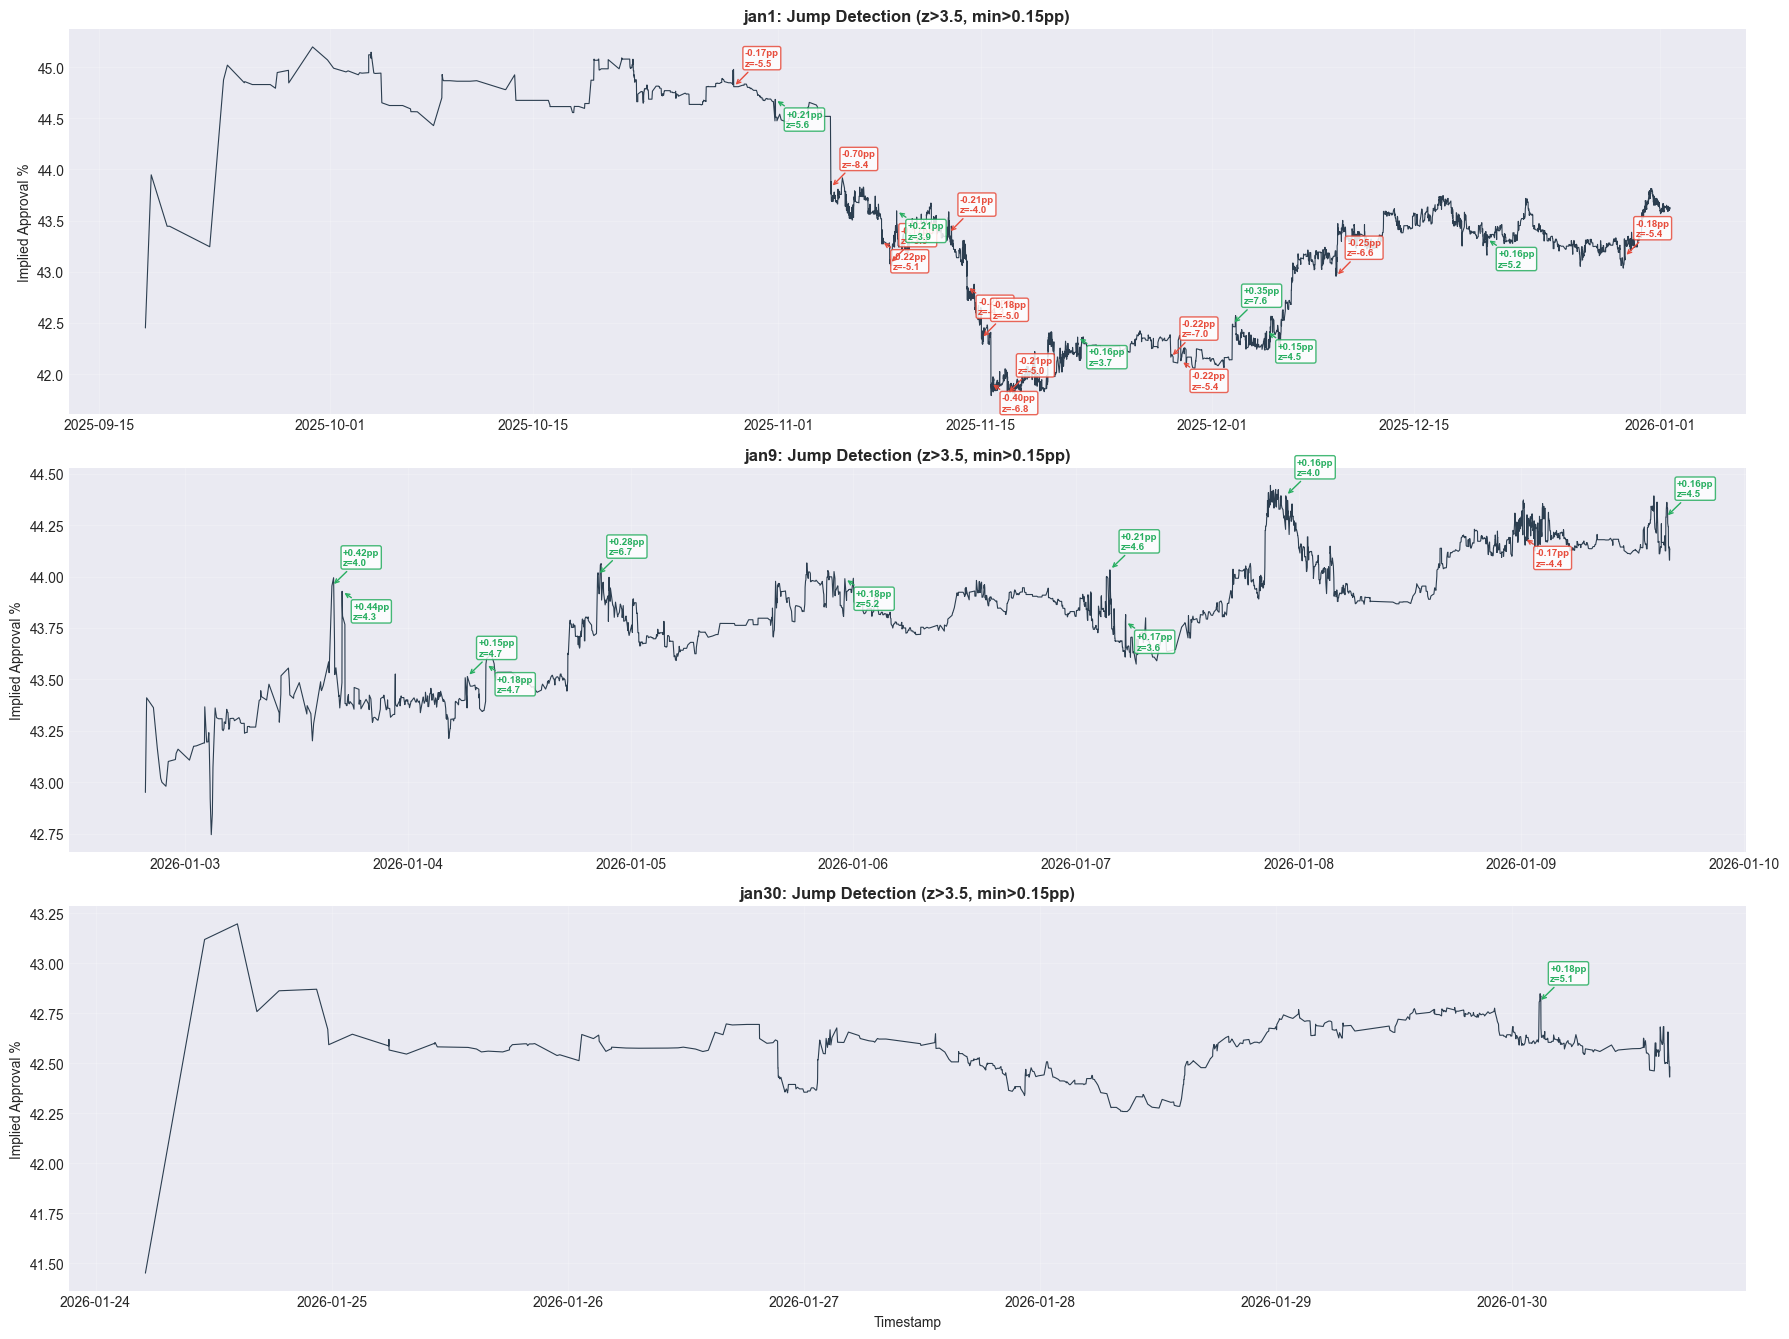

In [9]:
datasets = [
    ('jan1', jan1_stats),
    ('jan9', jan9_stats),
    ('jan30', jan30_stats),
]

plot_jumps(datasets, z_thresh=3.5, min_pp=0.15)

In [ ]:
def classify_jumps(jumps):
    """
    classify each jump as 'major' or 'minor' based on that contract's
    own distribution of detected jump sizes.
    
    threshold: a jump is 'major' if |change| >= median(|all detected changes|).
    this naturally adapts:
      - jan1 has big moves, so median is higher → filters out small ones
      - jan30 has small moves, so median is lower → keeps the meaningful ones
    
    also always keeps the single largest up and largest down regardless.
    """
    if len(jumps) == 0:
        return jumps
    
    abs_changes = jumps['change'].abs()
    median_size = abs_changes.median()
    
    # major = above median OR the single biggest up/down
    idx_biggest_up = jumps.loc[jumps['change'] > 0, 'change'].idxmax() if (jumps['change'] > 0).any() else None
    idx_biggest_down = jumps.loc[jumps['change'] < 0, 'change'].idxmin() if (jumps['change'] < 0).any() else None
    
    always_keep = {idx_biggest_up, idx_biggest_down} - {None}
    
    jumps = jumps.copy()
    jumps['abs_change'] = abs_changes
    jumps['tier'] = 'minor'
    jumps.loc[jumps['abs_change'] >= median_size, 'tier'] = 'major'
    jumps.loc[jumps.index.isin(always_keep), 'tier'] = 'major'
    
    return jumps

In [ ]:
# run detection + classification on all three contracts
datasets = [("jan1", jan1_stats), ("jan9", jan9_stats), ("jan30", jan30_stats)]
results = {}

for name, stats_df in datasets:
    print(f"\n{'─'*60}\n{name}\n{'─'*60}")
    jumps = detect_jumps_adaptive(stats_df, sensitivity=1.2)
    classified = classify_jumps(jumps)
    results[name] = classified

    # summary stats
    n_major = (classified['tier'] == 'major').sum()
    n_minor = (classified['tier'] == 'minor').sum()
    median_thresh = classified['abs_change'].median()

    print(f"  classification threshold (median |Δ|): {median_thresh:.3f}pp")
    print(f"  {n_major} major + {n_minor} minor = {len(classified)} total\n")

    # print each jump as a row
    print(f"  {'Timestamp (UTC)':<26} {'Implied%':>9} {'Change':>9} {'Z-Score':>8} {'Dir':>5}  Tier")
    print(f"  {'─'*70}")

    for _, j in classified.sort_values('timestamp').iterrows():
        z_str = f"{j['z_score']:.1f}" if pd.notna(j['z_score']) else "n/a"
        arrow = "↑" if j['direction'] == 'up' else "↓"
        print(f"  {str(j['timestamp']):<26} {j['implied_mean']:>8.2f}%  {j['change']:>+7.2f}pp  {z_str:>6}  {arrow:>3}  {j['tier']}")

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(20, 15))

for ax, (name, stats_df) in zip(axes, datasets):
    classified = results[name].sort_values('timestamp')
    n_major = (classified['tier'] == 'major').sum()
    n_total = len(classified)
    
    # time series
    ax.plot(stats_df['timestamp'], stats_df['implied_mean'], '-', color='#2c3e50', lw=0.8)
    
    # minor jumps: just a small dot, no label
    minor = classified[classified['tier'] == 'minor']
    for _, j in minor.iterrows():
        c = '#e74c3c' if j['direction'] == 'down' else '#27ae60'
        ax.plot(j['timestamp'], j['implied_mean'], 'o', color=c, ms=4, alpha=0.5)
    
    # major jumps: full annotation with number and timestamp
    major = classified[classified['tier'] == 'major']
    offsets = [25, -32, 38, -42, 22, -28, 34, -38, 18, -24]
    
    for i, (_, j) in enumerate(major.iterrows(), 1):
        c = '#e74c3c' if j['direction'] == 'down' else '#27ae60'
        y_off = offsets[i % len(offsets)]
        
        ts_label = j['timestamp'].strftime('%m/%d %H:%M')
        z_str = f"z={j['z_score']:.1f}" if pd.notna(j['z_score']) else "early"
        
        ax.annotate(
            f"#{i}  {j['change']:+.2f}pp  ({z_str})\n{ts_label}",
            xy=(j['timestamp'], j['implied_mean']),
            fontsize=7, fontweight='bold', color=c,
            xytext=(10, y_off), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', color=c, lw=0.8),
            bbox=dict(boxstyle='round,pad=0.25', fc='white', ec=c, alpha=0.9),
        )
    
    ax.set_title(f'{name}: {n_major} major jumps (of {n_total} detected, threshold = median |Δ|)',
                 fontweight='bold', fontsize=11)
    ax.set_ylabel('Implied Approval %')
    ax.grid(True, alpha=0.15)

axes[-1].set_xlabel('Timestamp')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/major_jumps.png', dpi=150, bbox_inches='tight')
plt.show()